In [ ]:
# import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from scipy.io import loadmat

def readdotmatdata(filename_mat):

  """
  Returns 
      arrays:
          times, [1 x samples]
          data,  [channels x samples x trials]
          fs, [1 x 1] 
      list
          labels [ channels x 1]

  """
  
  EEG = loadmat(filename_mat)

  # extract the necessary information
  times = np.squeeze(EEG['EEG'][0][0][14])
  data  = EEG['EEG'][0][0][15]
  fs    = EEG['EEG'][0][0][11][0][0].astype(int) # sampling rate

  labels = []
  for i in range(64):
    labels.append(EEG['EEG'][0][0][21][0][i][0][0])

  return times, data, fs, labels

In [ ]:
from google.colab import files # if you use google.colab
uploaded = files.upload()

# convolution with gaussian - Figure 11.12

times, data, fs, labels = readdotmatdata('sampleEEGdata.mat')
print('data loaded correctly')


Saving sampleEEGdata.mat to sampleEEGdata (1).mat
data loaded correctly


In [ ]:
eegdat4convol = data[0, :, 0]

# Task 1

In [ ]:
#create Gaussian 
time_g = np.arange(-1, 1, 1/fs)
g_width  = 30 
n_cycles = 5 
s= n_cycles/(2*np.pi*g_width) 
gaussian = np.exp((-time_g**2)/(2*s**2))/g_width ;

dt = 1 / fs
time_s = np.arange(start=dt - 1, stop=dt * (len(times) + 1) - 1, step=dt);
T = time_s.shape[0] * dt

####################################  1  #################################### 
def convolve(eegdat4convol,gaussian):
  return np.convolve(eegdat4convol,gaussian,'same')
  

####################################  2  ####################################  

def DFT(eegdat4convol,gaussian, T, time_g, time_s):

  N = len(eegdat4convol)
  nyquist = fs/2

  # initialize Fourier coefficients
  fourier_s = np.zeros(N,dtype=complex)
  frequencies  = np.linspace(0,nyquist,int(N/2+1))
  pos_freq = np.arange(0,int(N/2+1))

  for f in range(N):
    sine_wave = np.exp(-1j*2*np.pi*f/T*time_s)
    fourier_s[f] = np.dot(sine_wave,eegdat4convol)
  fourier_s = fourier_s/N


  fourier_g = np.zeros(N)
  for f in range(N):
    sine_wave = np.exp(-1j*2*np.pi*f/T*time_g)
    fourier_g[f] = np.dot(sine_wave,gaussian)
  fourier_g = fourier_g / N

  idft = fourier_s * fourier_g

  reconstructed = np.zeros(len(idft)) 
  for f in range(N):
    sine_wave = np.exp(1j*2*np.pi*f/T*time_s)
    reconstructed +=  np.real(idft[f]*sine_wave)

  # ax[0].plot(time, eegdat4convol,label='original data')
  return reconstructed
  

####################################  3  #################################### 
 
def FFT(eegdat4convol, gaussian):
  nfft = len(eegdat4convol) + len(gaussian)
  N2cut =np.floor(len(gaussian) / 2)
  pos_freq = np.arange(0,int(nfft/2)) 
  fft_s= np.abs(np.fft.fft(eegdat4convol,nfft))
  fft_g= np.abs(np.fft.fft(gaussian,nfft))
  fft_s= fft_s[pos_freq]/max(fft_s)
  fft_g= fft_g[pos_freq]/max(fft_g)   
  return np.fft.ifft(fft_s*fft_g, nfft)[int(N2cut):-int(N2cut)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(63.125, 0.5, 'Amplitude')

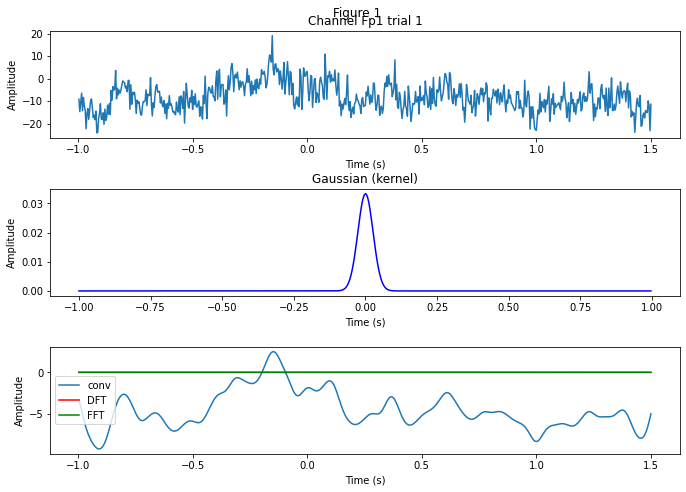

In [ ]:
conv = convolve(eegdat4convol, gaussian);
idft = DFT(eegdat4convol, gaussian, T, time_g, time_s)
ifft = FFT(eegdat4convol, gaussian)

fig,ax = plt.subplots(3,1,figsize=(10,7));
fig.suptitle('Figure 1', fontsize=12)
fig.tight_layout(pad=3.0)
ax[0].plot(time_s,eegdat4convol);
ax[0].set_title(f'Channel {labels[0]} trial 1');
ax[1].plot(time_g,gaussian,'b')
ax[1].set_title('Gaussian (kernel)');
ax[2].plot(time_s,conv, label='conv');
ax[2].plot(time_s, idft, 'r',label='DFT');
ax[2].plot(time_s,ifft,'g',label ='FFT') ;

ax[2].legend();

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')

ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')

# Task 2

In [ ]:
%timeit 1000
np.convolve(eegdat4convol,gaussian,'same');

100000000 loops, best of 5: 12.5 ns per loop


In [ ]:
times[-1], time_s[-1]

(1496.09375, 1.5)

In [ ]:
import time 
start = time.time()
for _ in range(1000):
  np.convolve(eegdat4convol,gaussian,'same')
end = time.time()
conv_time = end - start
conv_time

0.13628888130187988

In [ ]:
start = time.time()
for _ in range(1000):
  DFT(eegdat4convol, gaussian, T, time_g, time_s)
dft_time = time.time() - start

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
dft_time 

113.30205774307251

In [ ]:
start = time.time()
for _ in range(1000):
  FFT(eegdat4convol, gaussian)
fft_time = time.time() - start

fft_time

0.3942537307739258

Text(0, 0.5, 'Time (s)')

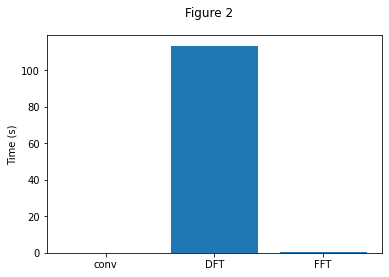

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Figure 2', fontsize=12)

ax.bar(['conv', 'DFT', 'FFT'], [conv_time, dft_time, fft_time])

ax.set_ylabel('Time (s)')

# Task 3

In [ ]:
frequencies.shape

(320,)

In [ ]:
int(nfft/2)

320

Text(0, 0.5, 'Power')

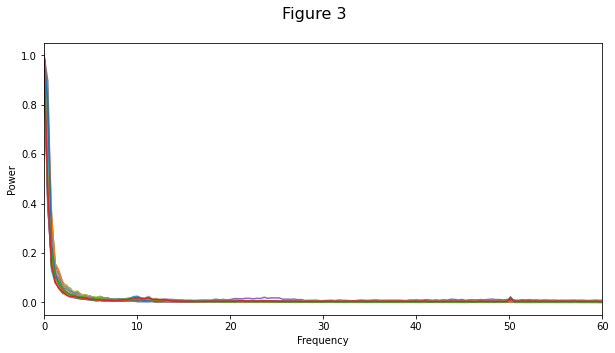

In [ ]:
nfft = data.shape[1]
pos_freq = np.arange(0,int(nfft/2))
fft_s = np.abs(np.fft.fft(data, n=nfft, axis=1)).mean(axis=2)
fft_s = np.square(fft_s)
fft_s = fft_s[:,pos_freq]

frequencies  = np.linspace(0,fs/2,int(nfft/2))

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Figure 3', fontsize=16)
for i in range(data.shape[0]):
  power_spectrum = fft_s[i]/max(fft_s[i])
  ax.plot(frequencies,power_spectrum) ;
  ax.set_xlim([0, 60])

ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

In [ ]:
theta = (frequencies >= 8 ) & (frequencies < 12) ;
power_spectrum_avg = fft_s[:,theta].mean(axis=1)

In [ ]:
power_spectrum_avg.shape

(64,)

In [ ]:
!pip install mne
import mne 
from mne.viz import plot_topomap

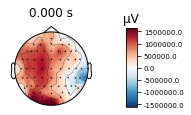

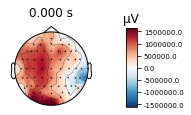

In [ ]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data_fake = rng.normal(size=(n_channels, 1)) * 1e-6

data_mne = mne.EvokedArray(power_spectrum_avg.reshape(64, 1), fake_info) # Is it okey????
data_mne.times = times
data_mne.data = np.mean(data,axis=2)
data_mne.set_montage(biosemi_montage)

times2plot = np.array([0])
times2plot

data_mne.plot_topomap(times2plot, ch_type='eeg', time_unit='s')